In [1]:
import time
import math
import random
from collections import Counter
from random import random as rand_float
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Importing data

In [4]:
file_path = "/content/spa.txt"
MAX_SAMPLES = 10000
SEED = 42

def load_sentence_pairs(path):
    with open(path, encoding="utf-8") as file:
        return [
            (src.lower(), tgt.lower())
            for line in file
            for parts in [line.rstrip().split("\t")]
            if len(parts) >= 2
            for src, tgt in [parts[:2]]
        ]

# Load and limit data
sentence_pairs = load_sentence_pairs(file_path)[:MAX_SAMPLES]

# Dataset splits
train_data, holdout_data = train_test_split(
    sentence_pairs, test_size=0.2, random_state=SEED
)

val_pairs, test_pairs = train_test_split(
    holdout_data, test_size=0.5, random_state=SEED
)

print(f"Training samples : {len(train_data)}")
print(f"Validation samples: {len(val_pairs)}")
print(f"Test samples      : {len(test_pairs)}")

Training samples : 8000
Validation samples: 1000
Test samples      : 1000


In [3]:
MAX_LEN = 40
BATCH_SIZE = 64
EMB_SIZE = 256
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT = 0.1
EPOCHS = 40
LR = 0.0005

# Preprocessing

In [5]:
def split_tokens(text: str):
    return text.strip().split()

# vocabulary construction
def create_vocabulary(paired_data):
    freq = Counter()

    for source, target in paired_data:
        freq.update(split_tokens(source))
        freq.update(split_tokens(target))

    base_tokens = ["<pad>", "<bos>", "<eos>", "<unk>"]
    vocab_map = {tok: idx for idx, tok in enumerate(base_tokens)}

    for token in freq:
        vocab_map[token] = len(vocab_map)

    return vocab_map

# build vocab
vocab = create_vocabulary(train_data)
reverse_vocab = dict(zip(vocab.values(), vocab.keys()))

PAD_IDX = vocab["<pad>"]
SOS_IDX = vocab["<bos>"]
EOS_IDX = vocab["<eos>"]
UNK_IDX = vocab["<unk>"]

VOCAB_SIZE = len(vocab)
print(f"Vocabulary size → {VOCAB_SIZE}")


def sentence_to_ids(text):
    token_ids = [vocab.get(tok, UNK_IDX) for tok in split_tokens(text)]
    sequence = [SOS_IDX] + token_ids + [EOS_IDX]

    if len(sequence) > MAX_LEN:
        sequence = sequence[:MAX_LEN]
    else:
        sequence.extend([PAD_IDX] * (MAX_LEN - len(sequence)))

    return sequence


def vectorize_pairs(pairs):
    src_ids, tgt_ids = zip(
        *[(sentence_to_ids(s), sentence_to_ids(t)) for s, t in pairs]
    )
    return torch.LongTensor(src_ids), torch.LongTensor(tgt_ids)


train_src, train_tgt = vectorize_pairs(train_data)
val_src, val_tgt     = vectorize_pairs(val_pairs)
test_src, test_tgt   = vectorize_pairs(test_pairs)

Vocabulary size → 8377


# Transformer

In [6]:
class PositionEmbedding(nn.Module):
    def __init__(self, dim, max_positions=5000):
        super().__init__()

        positions = torch.arange(max_positions, dtype=torch.float32).view(-1, 1)
        scale = torch.exp(
            -math.log(10000.0) * torch.arange(0, dim, 2).float() / dim
        )

        encoding = torch.zeros(max_positions, dim)
        encoding[:, 0::2] = torch.sin(positions * scale)
        encoding[:, 1::2] = torch.cos(positions * scale)

        self.register_buffer("pos_encoding", encoding.unsqueeze(0))

    def forward(self, embeddings: torch.Tensor) -> torch.Tensor:
        seq_len = embeddings.size(1)
        return embeddings + self.pos_encoding[:, :seq_len, :]

In [7]:
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()

        # embeddings
        self.encoder_embed = nn.Embedding(VOCAB_SIZE, EMB_SIZE)
        self.decoder_embed = nn.Embedding(VOCAB_SIZE, EMB_SIZE)

        self.position_layer = PositionEmbedding(EMB_SIZE)

        # core transformer
        self.core = nn.Transformer(
            d_model=EMB_SIZE,
            nhead=NHEAD,
            num_encoder_layers=NUM_ENCODER_LAYERS,
            num_decoder_layers=NUM_DECODER_LAYERS,
            dim_feedforward=FFN_HID_DIM,
            dropout=DROPOUT,
            batch_first=True
        )

        self.output_proj = nn.Linear(EMB_SIZE, VOCAB_SIZE)

    @staticmethod
    def padding_mask(seq):
        return seq.eq(PAD_IDX)

    @staticmethod
    def causal_mask(size, device):
        return torch.triu(
            torch.ones(size, size, device=device), diagonal=1
        ).bool()

    # forward pass
    def forward(self, src_seq, tgt_seq):
        src_pad_mask = self.padding_mask(src_seq)
        tgt_pad_mask = self.padding_mask(tgt_seq)
        tgt_causal_mask = self.causal_mask(tgt_seq.size(1), tgt_seq.device)

        enc_input = self.position_layer(self.encoder_embed(src_seq))
        dec_input = self.position_layer(self.decoder_embed(tgt_seq))

        transformer_out = self.core(
            enc_input,
            dec_input,
            src_key_padding_mask=src_pad_mask,
            tgt_key_padding_mask=tgt_pad_mask,
            tgt_mask=tgt_causal_mask
        )

        return self.output_proj(transformer_out)

In [8]:
model = Transformer().to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [9]:
def run_training_epoch(source_tensor, target_tensor):
    model.train()
    epoch_loss = 0.0
    steps = 0

    for start_idx in range(0, source_tensor.size(0), BATCH_SIZE):
        src_batch = source_tensor[start_idx:start_idx + BATCH_SIZE].to(device)
        tgt_batch = target_tensor[start_idx:start_idx + BATCH_SIZE].to(device)

        decoder_in = tgt_batch[:, :-1]
        decoder_out = tgt_batch[:, 1:]

        optimizer.zero_grad(set_to_none=True)

        logits = model(src_batch, decoder_in)

        loss = loss_fn(
            logits.view(-1, VOCAB_SIZE),
            decoder_out.contiguous().view(-1)
        )

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        steps += 1

    return epoch_loss / steps

In [10]:
@torch.no_grad()
def translate_greedy(source_sentence: str):
    model.eval()
    source_tensor = torch.LongTensor([sentence_to_ids(source_sentence)]).to(device)
    generated_tokens = torch.full(
        (1, 1),
        SOS_IDX,
        device=device,
        dtype=torch.long
    )
    for _ in range(MAX_LEN):
        model_outputs = model(source_tensor, generated_tokens)
        # Select most probable next token
        next_token_id = torch.argmax(
            model_outputs[:, -1, :], dim=-1
        )
        # Append predicted token
        generated_tokens = torch.cat(
            [generated_tokens, next_token_id.unsqueeze(1)],
            dim=1
        )
        # Stop if <EOS> is generated
        if next_token_id.item() == EOS_IDX:
            break
    return [
        reverse_vocab[token_id]
        for token_id in generated_tokens.squeeze(0).tolist()
    ]

In [11]:
bleu_smoothing_fn = SmoothingFunction().method1
def compute_average_bleu(dataset, max_samples=200):
    sampled_pairs = random.sample(
        dataset,
        k=min(max_samples, len(dataset))
    )
    bleu_scores = []
    for source_sentence, reference_sentence in sampled_pairs:
        predicted_tokens = translate_greedy(source_sentence)
        reference_tokens = split_tokens(reference_sentence)
        bleu_score = sentence_bleu(
            [reference_tokens],
            predicted_tokens,
            smoothing_function=bleu_smoothing_fn
        )
        bleu_scores.append(bleu_score)
    return float(np.mean(bleu_scores))

In [12]:
training_loss_history = []
validation_bleu_history = []
training_start_time = time.time()
for epoch_idx in range(EPOCHS):
    epoch_train_loss = run_training_epoch(train_src, train_tgt)
    training_loss_history.append(epoch_train_loss)
    epoch_bleu_score = compute_average_bleu(val_pairs)
    validation_bleu_history.append(epoch_bleu_score)

    print(f"\nEpoch [{epoch_idx + 1}/{EPOCHS}]")
    print(f"Training Loss : {epoch_train_loss:.4f}")
    print(f"Validation BLEU: {epoch_bleu_score:.4f}")

total_training_time = time.time() - training_start_time

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:531: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Epoch [1/40]
Training Loss : 5.6600
Validation BLEU: 0.0189

Epoch [2/40]
Training Loss : 4.3157
Validation BLEU: 0.0186

Epoch [3/40]
Training Loss : 3.6636
Validation BLEU: 0.0264

Epoch [4/40]
Training Loss : 3.1486
Validation BLEU: 0.0303

Epoch [5/40]
Training Loss : 2.7293
Validation BLEU: 0.0311

Epoch [6/40]
Training Loss : 2.3623
Validation BLEU: 0.0330

Epoch [7/40]
Training Loss : 2.0197
Validation BLEU: 0.0294

Epoch [8/40]
Training Loss : 1.7141
Validation BLEU: 0.0417

Epoch [9/40]
Training Loss : 1.4506
Validation BLEU: 0.0355

Epoch [10/40]
Training Loss : 1.2088
Validation BLEU: 0.0416

Epoch [11/40]
Training Loss : 0.9954
Validation BLEU: 0.0390

Epoch [12/40]
Training Loss : 0.8269
Validation BLEU: 0.0375

Epoch [13/40]
Training Loss : 0.6974
Validation BLEU: 0.0431

Epoch [14/40]
Training Loss : 0.6061
Validation BLEU: 0.0384

Epoch [15/40]
Training Loss : 0.5329
Validation BLEU: 0.0398

Epoch [16/40]
Training Loss : 0.4815
Validation BLEU: 0.0405

Epoch [17/40]
Tr

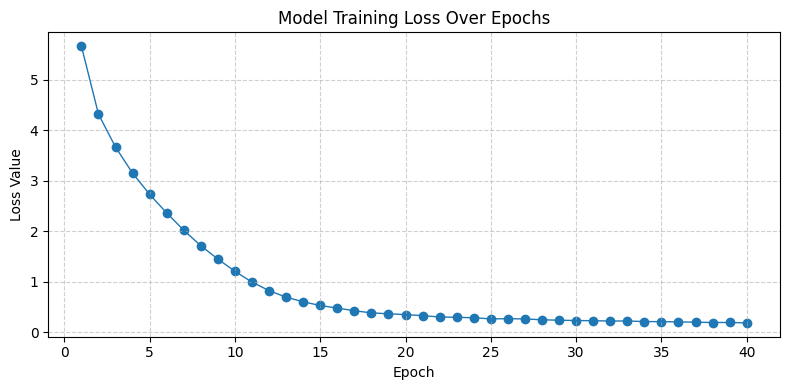

In [13]:
plt.figure(figsize=(8, 4))
epochs = range(1, len(training_loss_history) + 1)
plt.scatter(
    epochs,
    training_loss_history,
    marker="o"
)
plt.plot(
    epochs,
    training_loss_history,
    linewidth=1
)
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Model Training Loss Over Epochs")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

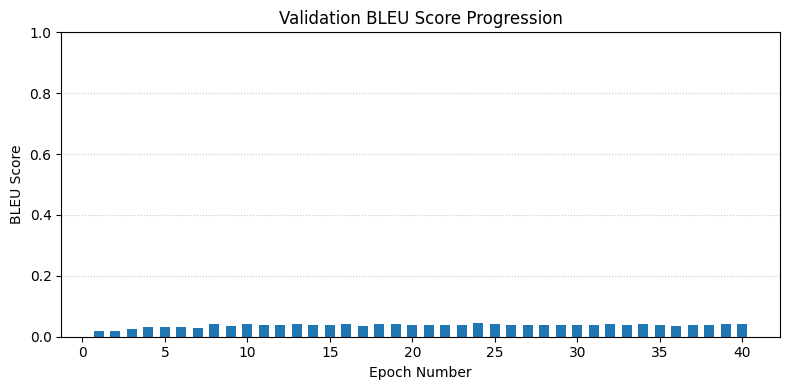

In [14]:
plt.figure(figsize=(8, 4))
epoch_indices = np.arange(1, len(validation_bleu_history) + 1)
plt.bar(
    epoch_indices,
    validation_bleu_history,
    width=0.6
)
plt.xlabel("Epoch Number")
plt.ylabel("BLEU Score")
plt.title("Validation BLEU Score Progression")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
final_test_bleu_score = compute_average_bleu(test_pairs)

print("\nFinal Evaluation Results ")
print(f"Test BLEU Score        : {final_test_bleu_score:.4f}")
print(f"Total Training Time(s): {total_training_time:.2f}")


Final Evaluation Results 
Test BLEU Score        : 0.0361
Total Training Time(s): 500.37


# Example Translations

In [17]:
sample_translations = random.sample(test_pairs, k=5)

for source_sentence, reference_sentence in sample_translations:
    predicted_tokens = translate_greedy(source_sentence)
    predicted_sentence = " ".join(predicted_tokens)

    print("\nSource (EN):", source_sentence)
    print("Reference :", reference_sentence)
    print("Prediction:", predicted_sentence)


Source (EN): stop the car.
Reference : pará el coche.
Prediction: <bos> deja que cruje. <eos>

Source (EN): he's strong.
Reference : él es fuerte.
Prediction: <bos> él es un guarro. <eos>

Source (EN): i hope it rains.
Reference : espero que llueva.
Prediction: <bos> yo guisaré. <eos>

Source (EN): is tom jealous?
Reference : ¿tom está celoso?
Prediction: <bos> ¿tom es candente. <eos>

Source (EN): i'll stop tom.
Reference : voy a detener a tom.
Prediction: <bos> yo voy a ser estúpido. <eos>
